In [18]:
# Generalized PSF Finder

In [19]:
from scipy.optimize import curve_fit
import random

from astropy.io import fits
import numpy as np
import scipy.interpolate
from scipy.interpolate import splev, splrep

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import pandas as pd

In [20]:
import ipywidgets as widgets

import pickle

In [21]:
with open('./shifted_values.pkl', 'rb') as f:
     loaded_data = pickle.load(f)

loaded_data

{'wavelength': 0     [4431.46137068054, 4431.476152444564, 4431.490...
 1     [4464.045010302595, 4464.059900753942, 4464.07...
 2     [4497.119781202617, 4497.134781979524, 4497.14...
 3     [4530.68121275581, 4530.696325481602, 4530.711...
 4     [4564.750958699148, 4564.76618506938, 4564.781...
                             ...                        
 66    [9061.78623925518, 9061.816466120454, 9061.846...
 67    [9486.57628353487, 9486.607927347213, 9486.639...
 68    [9637.169683115359, 9637.201829253212, 9637.23...
 69    [9792.632159733768, 9792.664824438625, 9792.69...
 70    [9953.17398115629, 9953.207181371019, 9953.240...
 Name: shifted wavelengths, Length: 71, dtype: object,
 'flux': 0     [0.8949158314042824, 0.7815706774264399, 0.828...
 1     [0.9304602218385664, 0.9055602214297426, 0.804...
 2     [0.9681062116715451, 0.9410797799020679, 1.068...
 3     [0.442616295897608, 0.43149351085405907, 0.322...
 4     [0.7329985280363767, 0.816532642581396, 0.6904...
           

In [22]:
#step 1: find the minima 
def minima_scanner_with_thresholds(x,y, thresholds):
    ''' sets minima flux value to be considered for a minima (threshold). must be less than 1'''
    min_x = []
    min_y = []
    for i in np.arange(1, len(x)-1):
        if y[i] > thresholds[0] and y[i] < thresholds[1]: 
            if y[i-1] > y[i] and y[i] < y[i+1]:
                min_x.append(x[i])
                min_y.append(y[i]) 
    return min_x, min_y   

In [23]:
#step 2: find maxima 
def simple_maxima(x, y, limit):
    ''' this requires min values and assumes a threshold has been applied'''
    l = limit #minimum value to be considered as a maxima 
    max_x = []
    max_y = []
    for i in np.arange(1, len(x)-1):
        if y[i] > l and y[i]:
            if y[i-1] < y[i] and y[i] > y[i+1]:
                max_x.append(x[i])
                max_y.append(y[i])
    return max_x, max_y


In [33]:
#step 3: see where minima fit in maxima array to create fitting domains
def find_range(x,y, intial_guess = False):
    ''' Given the parameters of a spectra, it will find the ranges of possible gaussian candidates. 
    the aim is for it to also give inital parameters estimations for curve fitting'''
    ranges = []
    outs = []
    minx, miny = minima_scanner_with_thresholds(x,y, [0.4,0.8])
    maxx, maxy = simple_maxima(x, y, 0.9)
    insertions = np.searchsorted(maxx, minx) #gives at which indeces to put the mininima in the maxima array to be sorted still. 
    
    tempxr = []
    tempyr = []
    tempxl = []
    tempyl = []
    
    
    for i in insertions: 
        tempxr.append(maxx[i])
        tempyr.append(maxy[i])
        tempxl.append(maxx[i-1])
        tempyl.append(maxy[i-1])

    for j in np.arange(len(tempxl)): 
        temprange = []
        tempout = []
        for i in np.arange(len(x)):
            if x[i] > tempxl[j] and x[i] < tempxr[j]:
                temprange.append(x[i])
                tempout.append(y[i])
        ranges.append(temprange)
        outs.append(tempout)
        
    #finds inital guesses:
    if intial_guess: 
        
        amps = []
        means = []
        stds = []
        for i in np.arange(len(ranges)):
            amps.append(min(outs[i]))
            means.append(ranges[i][np.argmin(outs[i])])
            stds.append(np.std(outs[i]))
        
        
        return ranges, outs, amps, means, stds
                
   #just returns ranges for graphing purposes 
    else:
        return ranges, outs

In [34]:
#step 4: fit to a guassian:
def gaussian(x,a, b, c):
    '''a is amplitude, b is  the mean (where i think it is), c is standard deviation (sqrt(variance))''' 
    #offset = x[0] #good estimate
    return -a*np.e**(-(x-b)**2/(2*c**2)) + 1 # + offset 

In [35]:
#step 5: return PSF value:
def return_psf(index = 0): #index goes to the length of the amps, means, and stds arrays 
    bfit, cov = curve_fit(gaussian,domains[index], ranges[index], p0 = [amps[index],means[index],stds[index]], absolute_sigma=True)
    #test_gaussian = gaussian(domains[index], bfit[0],bfit[1],bfit[2])
    return bfit[2] #this is the spread 

In [157]:
def psf_per_order(x,y):
    minx, miny = minima_scanner_with_thresholds(x,y, [0.2,0.8])
    maxx, maxy = simple_maxima(x, y, 0.9)
    domains, ranges, amps, means, stds = find_range(x,y, intial_guess = True)
    #gaussian(x,a, b, c)
    psfs = []
    def return_psf(index = 0): #index goes to the length of the amps, means, and stds arrays 
        bfit, cov = curve_fit(gaussian,domains[index], ranges[index], p0 = [amps[index],means[index],stds[index]], absolute_sigma=True)
        #test_gaussian = gaussian(domains[index], bfit[0],bfit[1],bfit[2])
        return bfit[2] #this is the spread 
    
    for i in np.arange(len(amps)):
        try:
            psf = return_psf(i)
            if psf > 0 and psf < 2:
                psfs.append(psf)
        except:
            pass
    return psfs

In [158]:
g = ...

wls = loaded_data['wavelength']
fls = loaded_data['flux']
order = np.arange(len(wls))



In [159]:
# some of these orders are kinda broken, would need to go back:
tot_psfs = []

for o in range(1,3):
    tot_psfs += psf_per_order(wls[o],fls[o])
for o in range(5,7):
    tot_psfs += psf_per_order(wls[o],fls[o])  
for o in range(8,18):
    tot_psfs += psf_per_order(wls[o],fls[o])
for o in range(21,24):
    tot_psfs += psf_per_order(wls[o],fls[o])
#psfs

C:\Users\alica\AppData\Local\Temp\ipykernel_37780\1209340471.py:5: RuntimeWarning: invalid value encountered in true_divide
  return -a*np.e**(-(x-b)**2/(2*c**2)) + 1 # + offset


In [160]:
len(tot_psfs)

1240

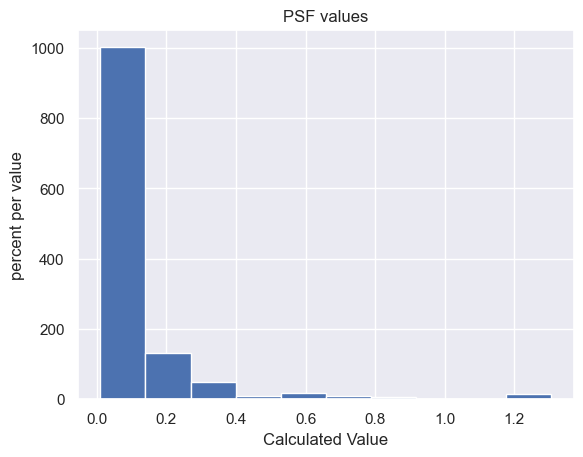

In [214]:
plt.hist(np.abs(tot_psfs))
plt.title('PSF values')
plt.xlabel('Calculated Value')
plt.ylabel('percent per value')
plt.show()

In [213]:
print('max PSF: ', max(tot_psfs), '\nMin PSF: ',min(tot_psfs), '\nMean PSF: ', np.mean(tot_psfs), '\nMedian PSF: ', np.median(tot_psfs)
     )

max PSF:  1.3062242723834834 
Min PSF:  0.010419030837926226 
Mean PSF:  0.11932119485479549 
Median PSF:  0.05882542105204383


In [172]:
#adding in random emission features:

def emission_periodic_gaussian(x,a, b, c):
    '''a is amplitude, b is  the mean (where i think it is), c is standard deviation (sqrt(variance))''' 
    #offset = x[0] #good estimate
    return a*np.e**(-(x-b)**2/(2*c**2)) + 1 # + offset


In [165]:
def periodic_gaussian(sigma,l,x,xprime,p):
    exponent = []
    function = []
    for i in x:
        exponent = np.append(exponent,-2/l**2 * (np.sin(np.pi*(((i-xprime)/p))))**2)
    function = np.append(function,sigma**2 * np.e**exponent)
    return function + 1

In [168]:
periodic_gaussian(1,1,np.arange(-5,5),1,1)

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

In [169]:
test_x = np.linspace(-10,10,1000)
test_gaussian2 = periodic_gaussian(1,1,test_x,1,10)
test_gaussian3 = periodic_gaussian(1,1,test_x,5.5,10)

In [171]:
# plt.figure(figsize=(10,6))
# plt.plot(test_x,test_gaussian2, label = 'no horizontal offset')
# plt.plot(test_x,test_gaussian3, label = 'horizontal offset = 1/2')
# plt.title('Test of periodic gaussian', fontsize = 18)
# plt.xlabel('unit of separation')
# plt.ylabel('amplitude')
# plt.legend(loc = 'upper right')
# plt.show()

In [180]:
fit_maybe = emission_periodic_gaussian(wls[0],0.1,np.mean(wls[0]), np.mean(tot_psfs))

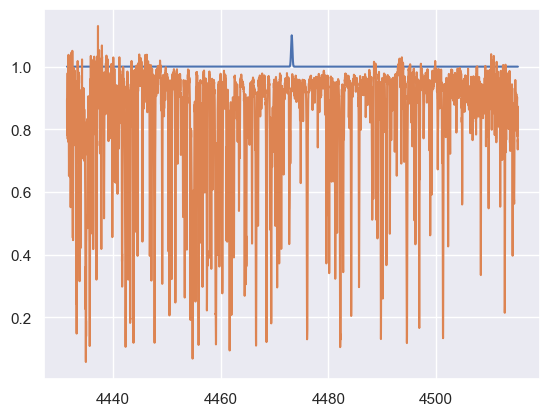

In [181]:
plt.plot(wls[0], fit_maybe)
plt.plot(wls[0],fls[0])

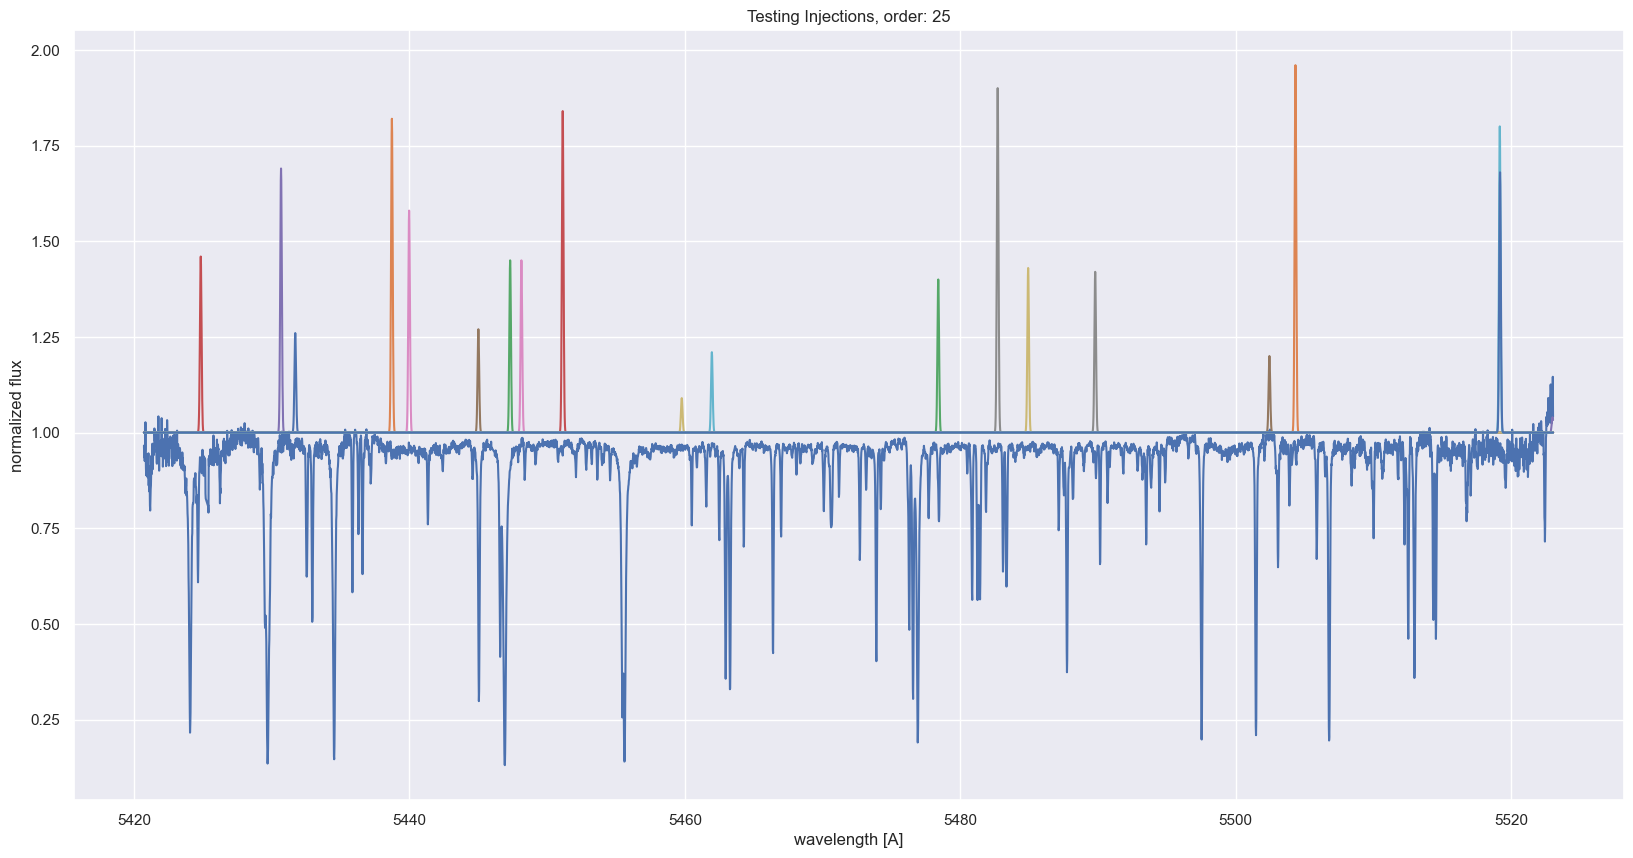

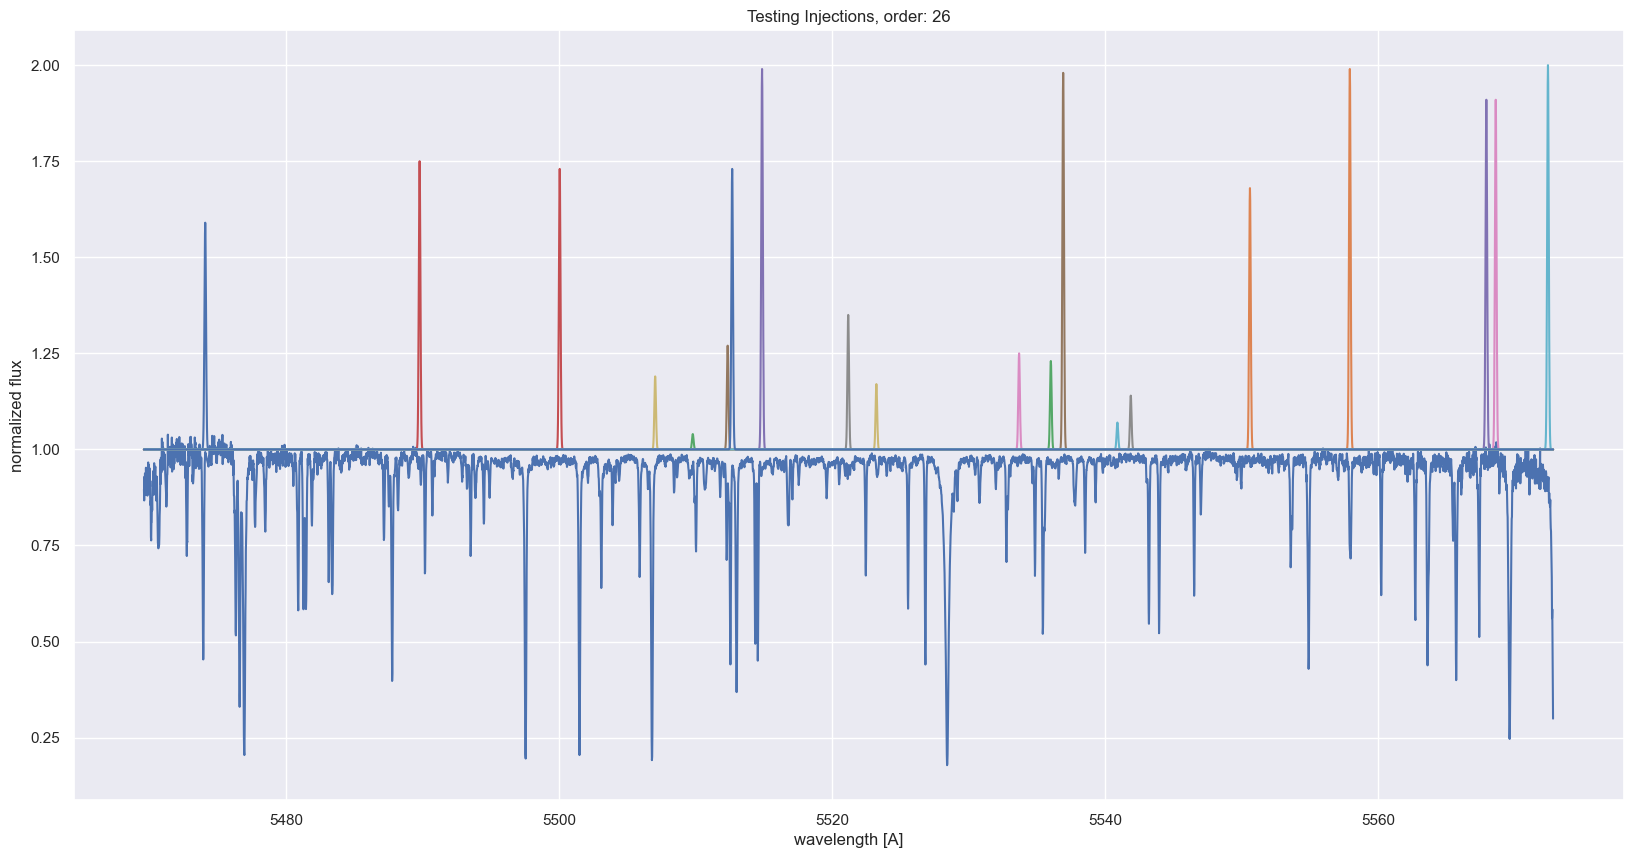

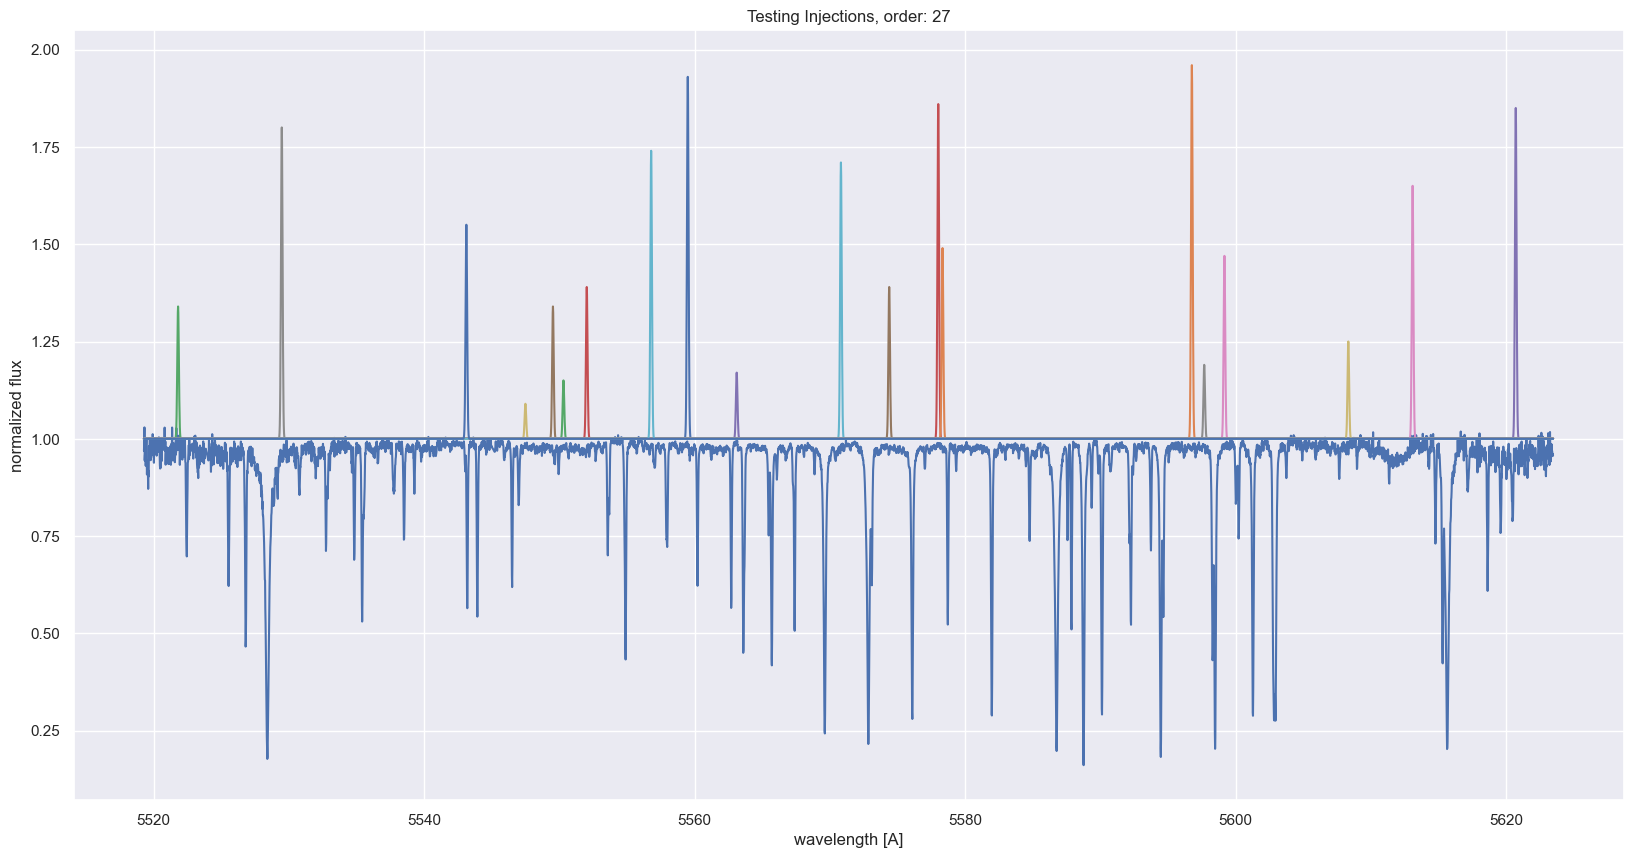

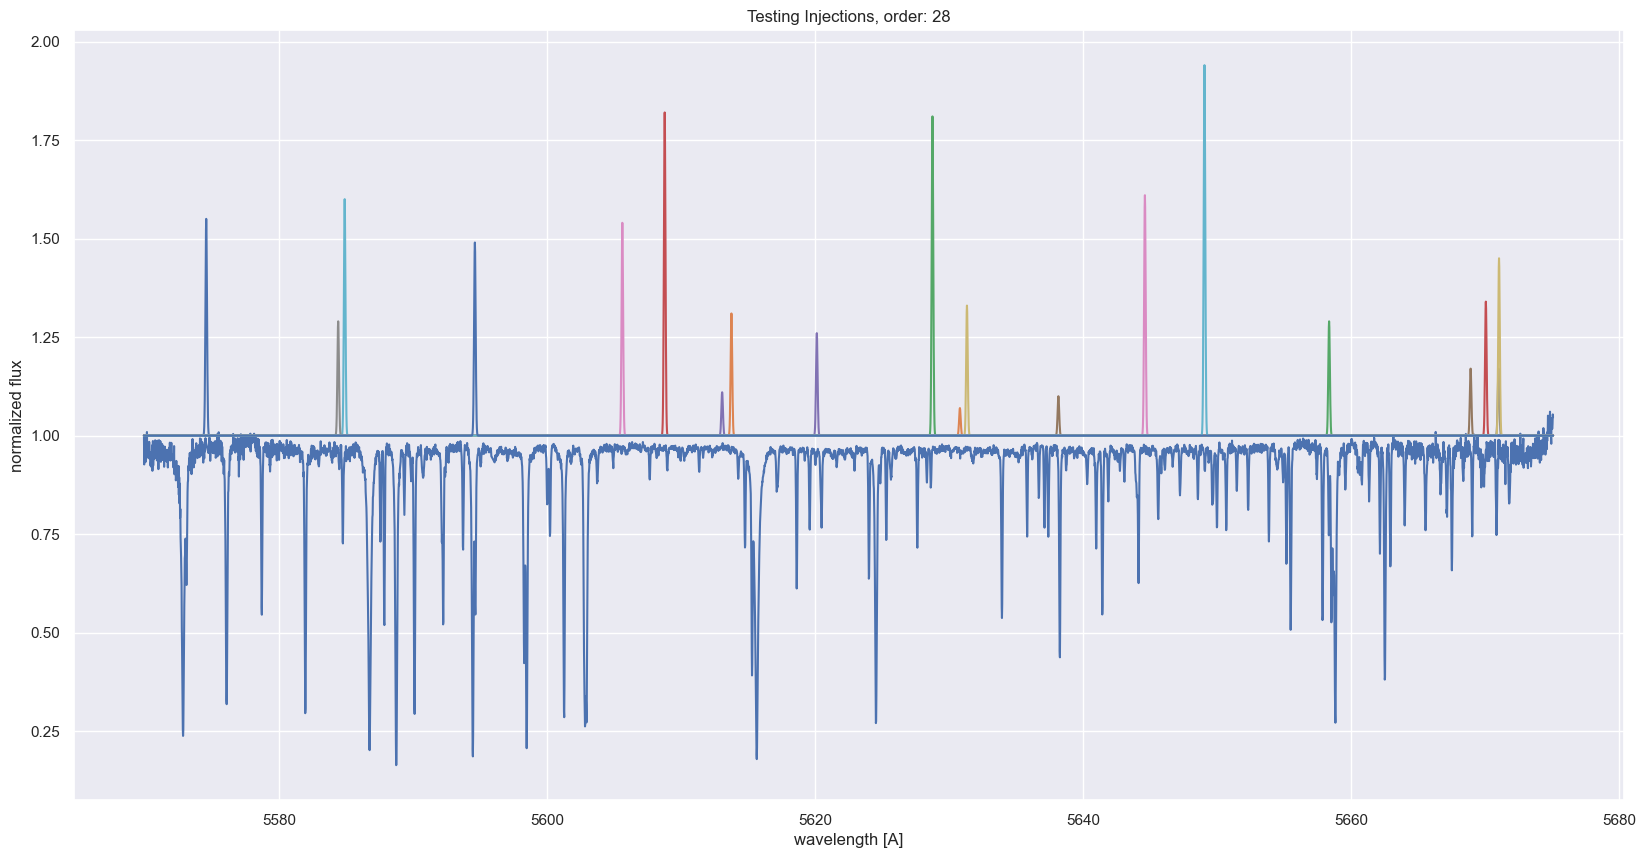

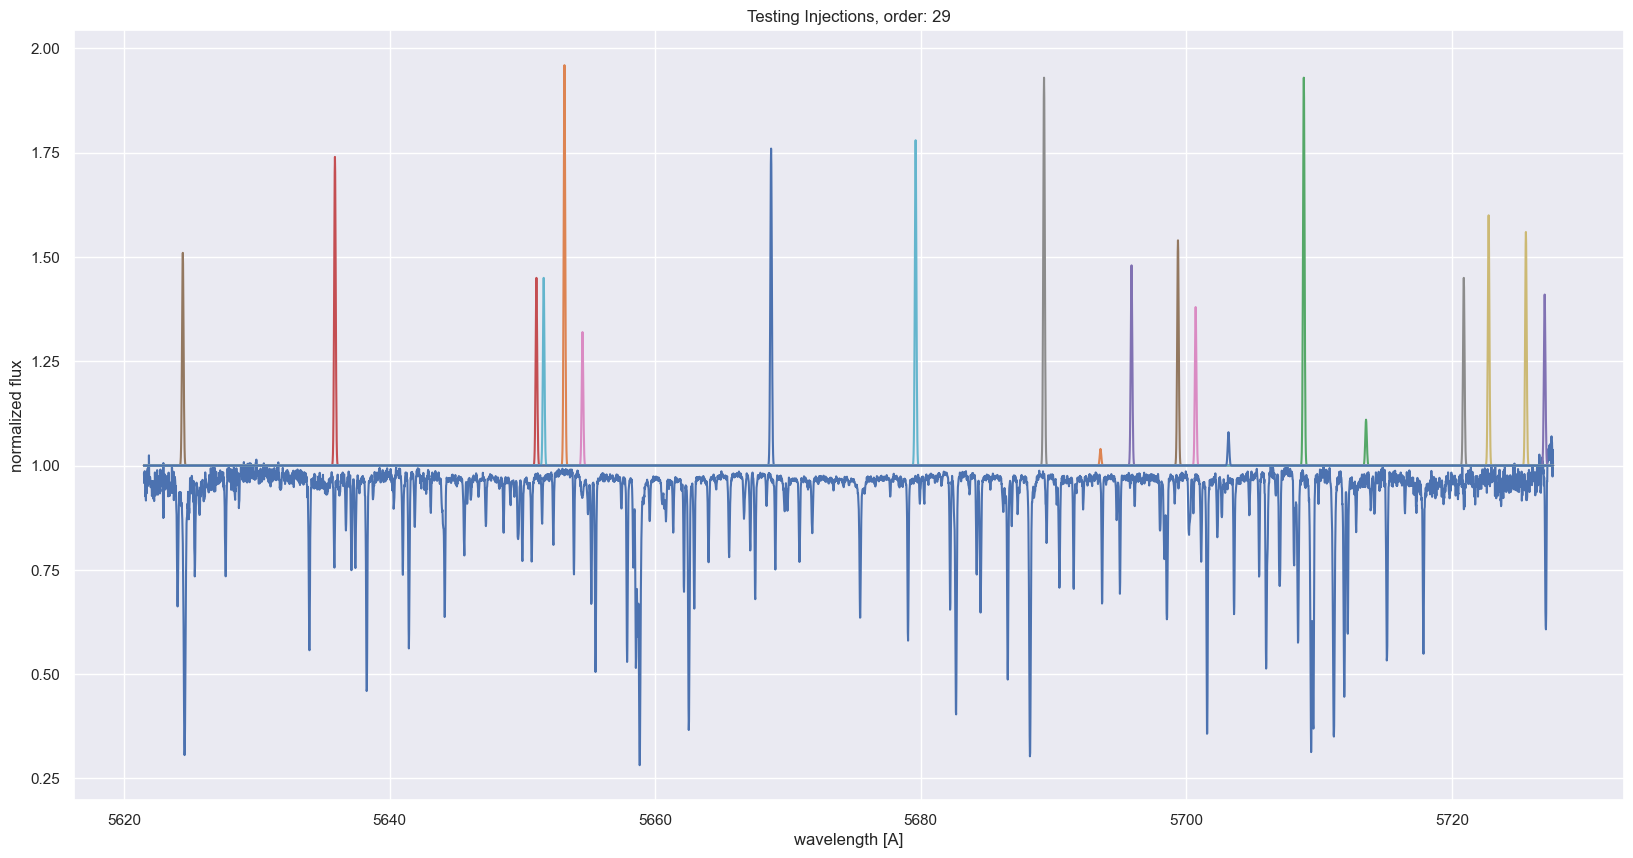

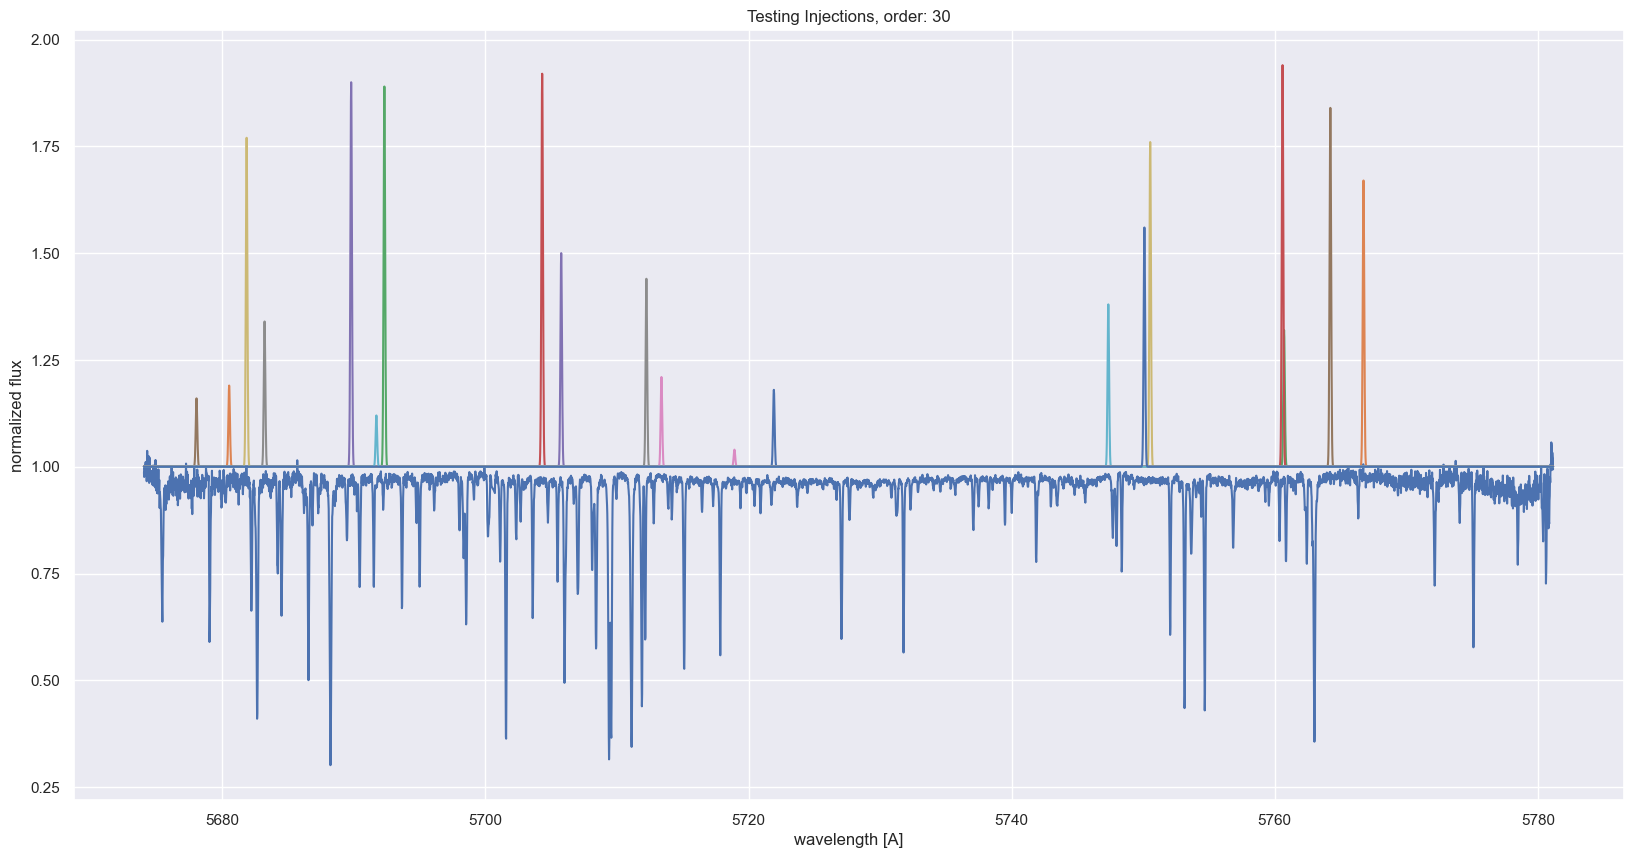

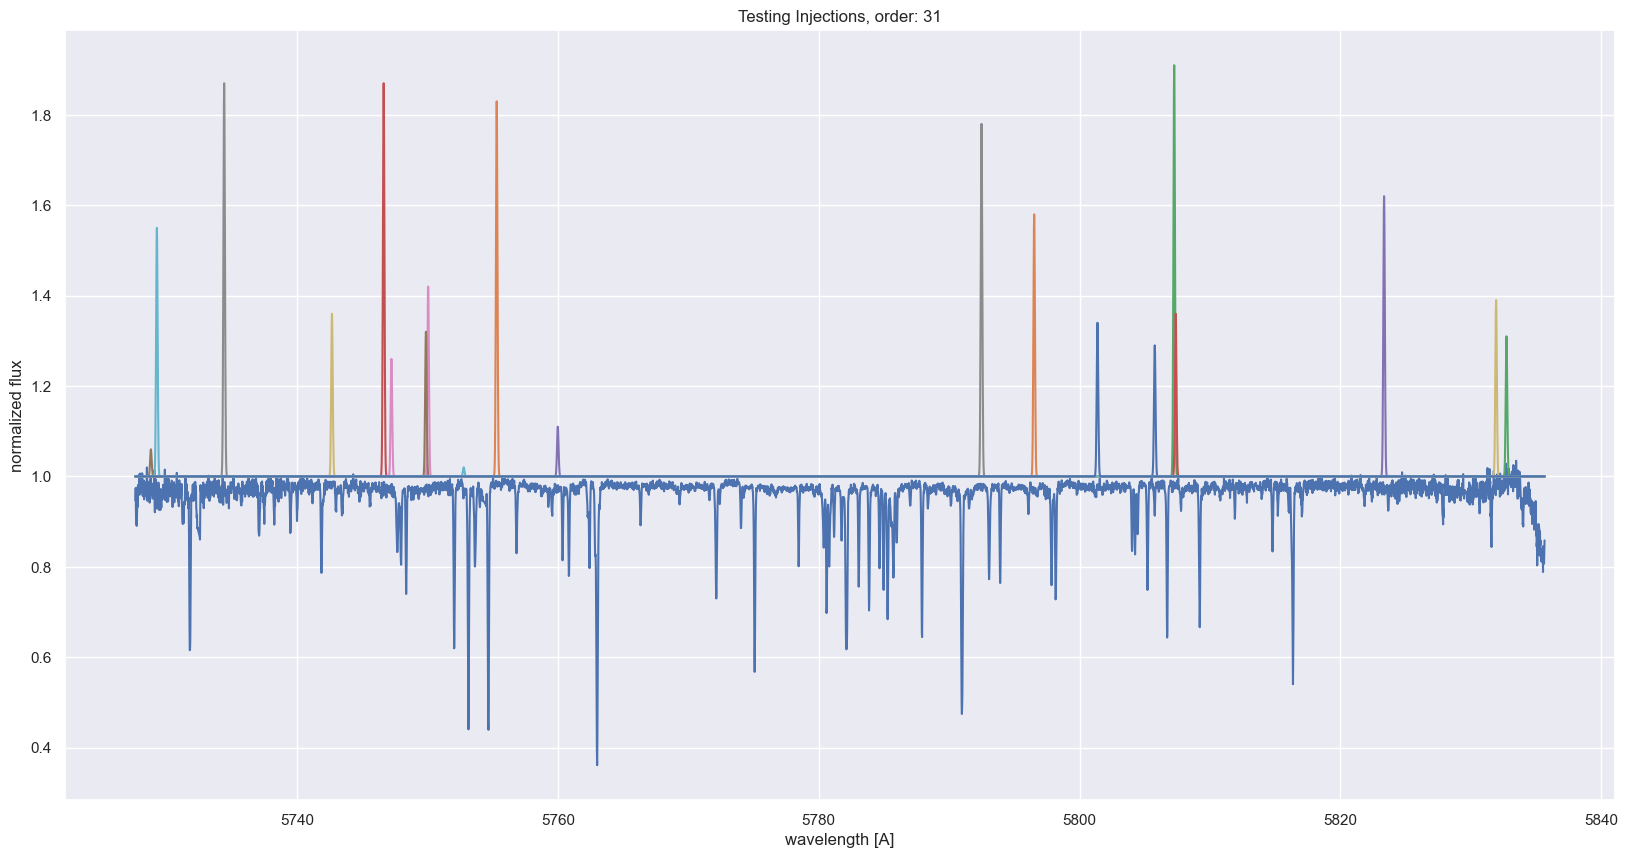

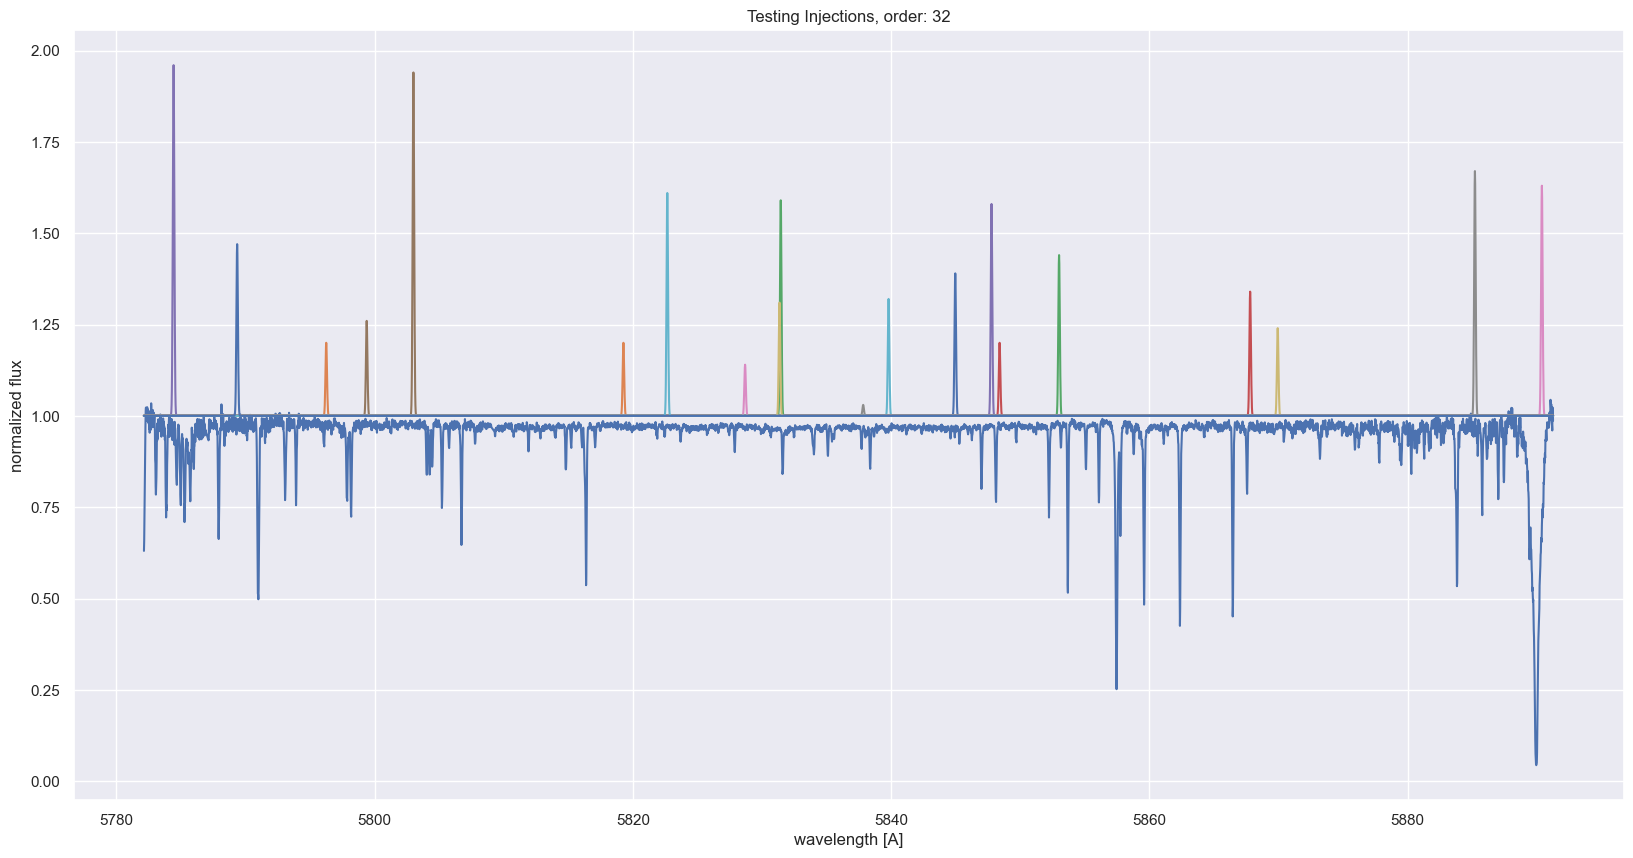

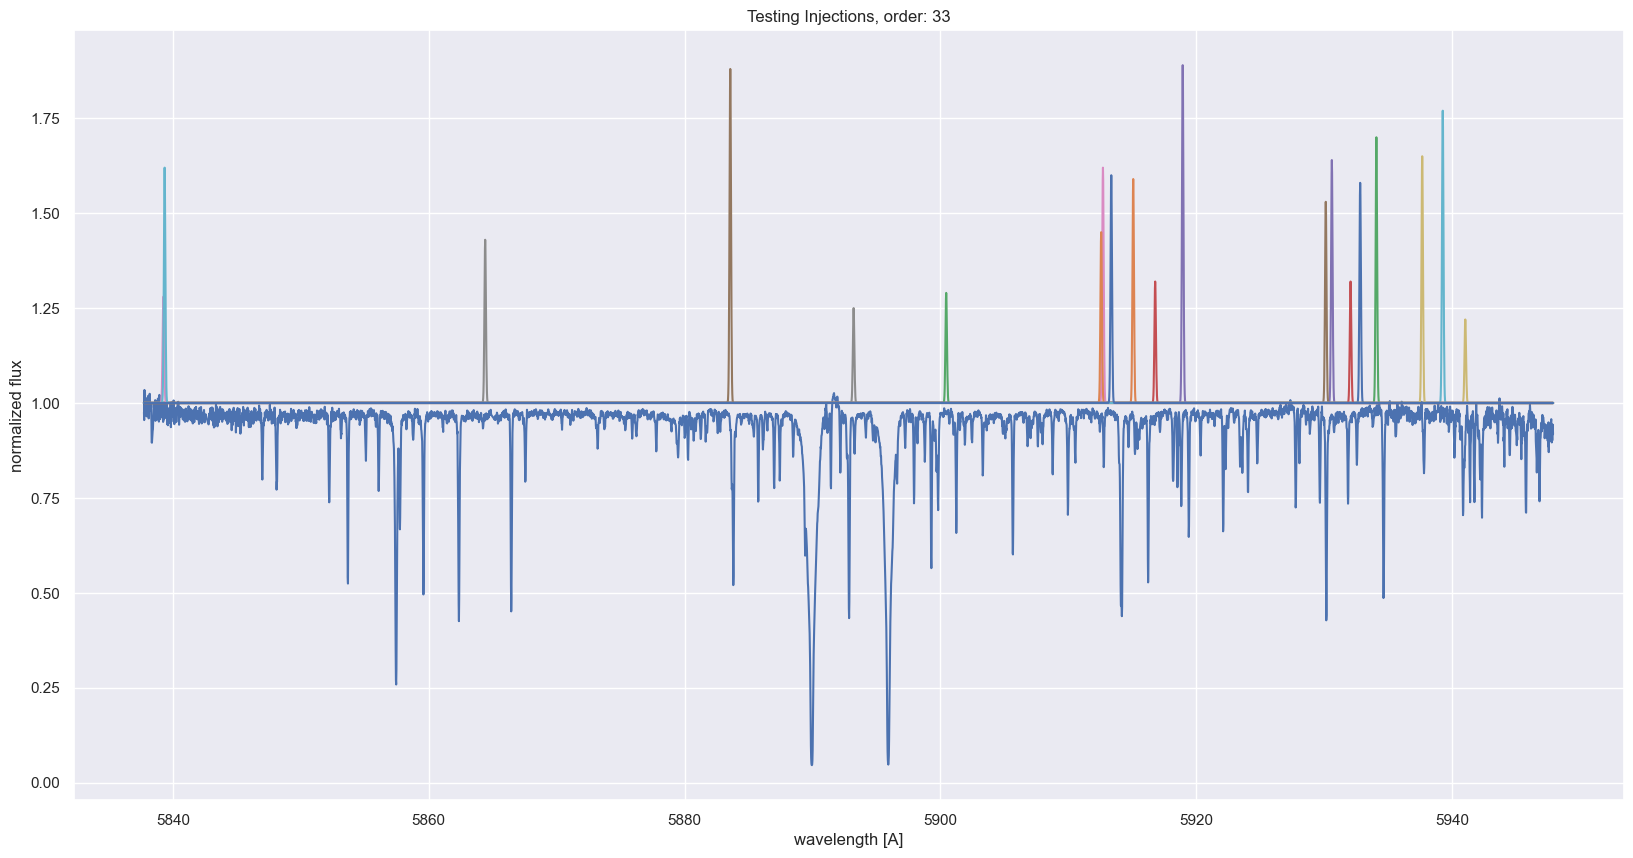

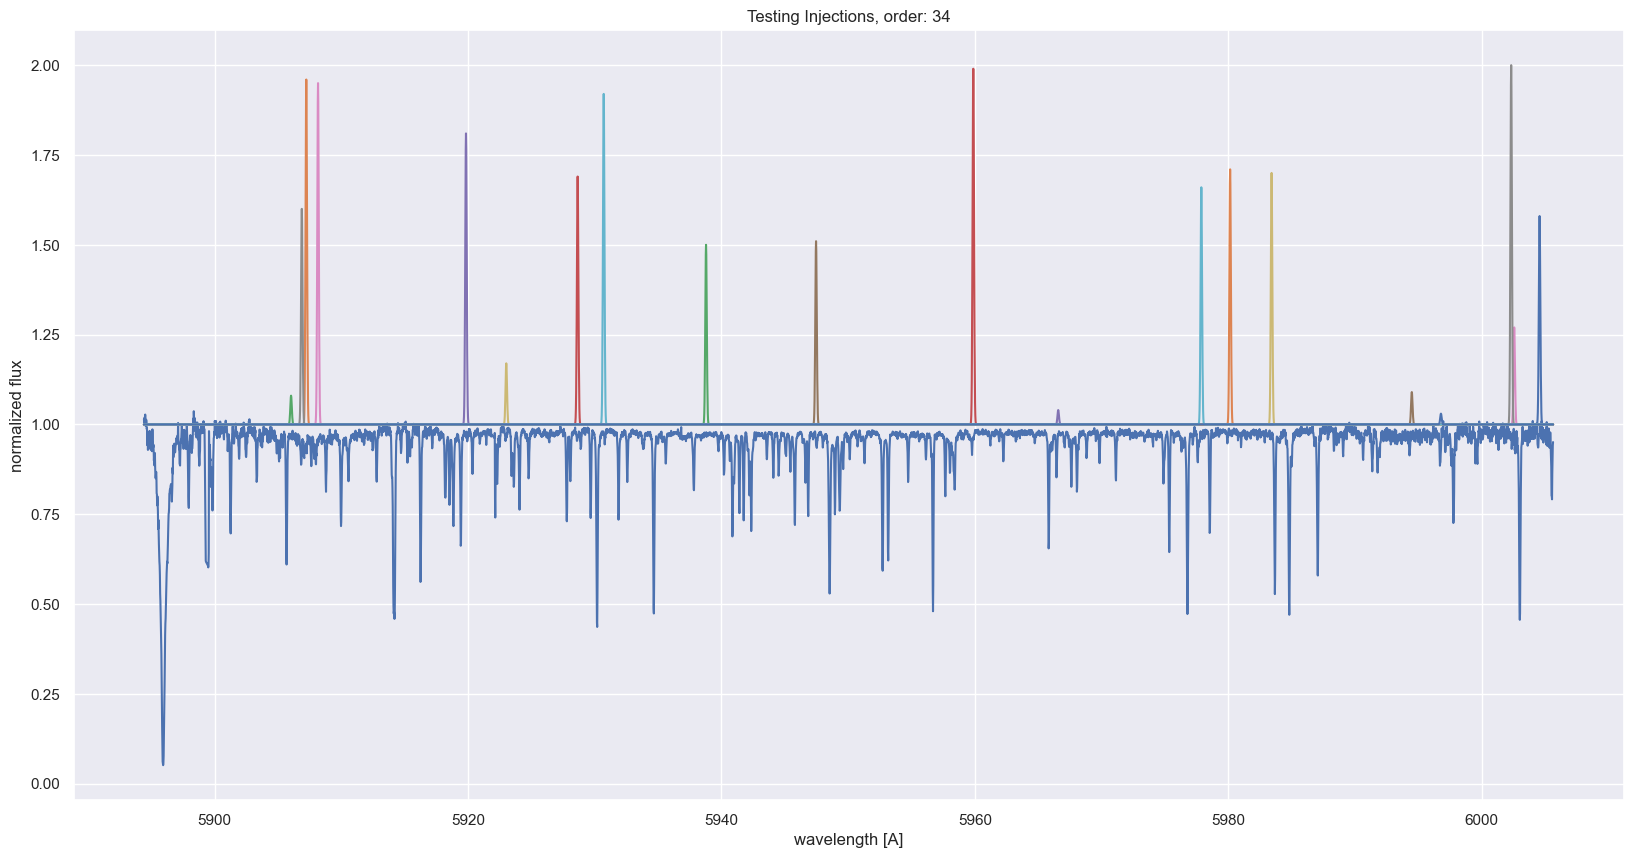

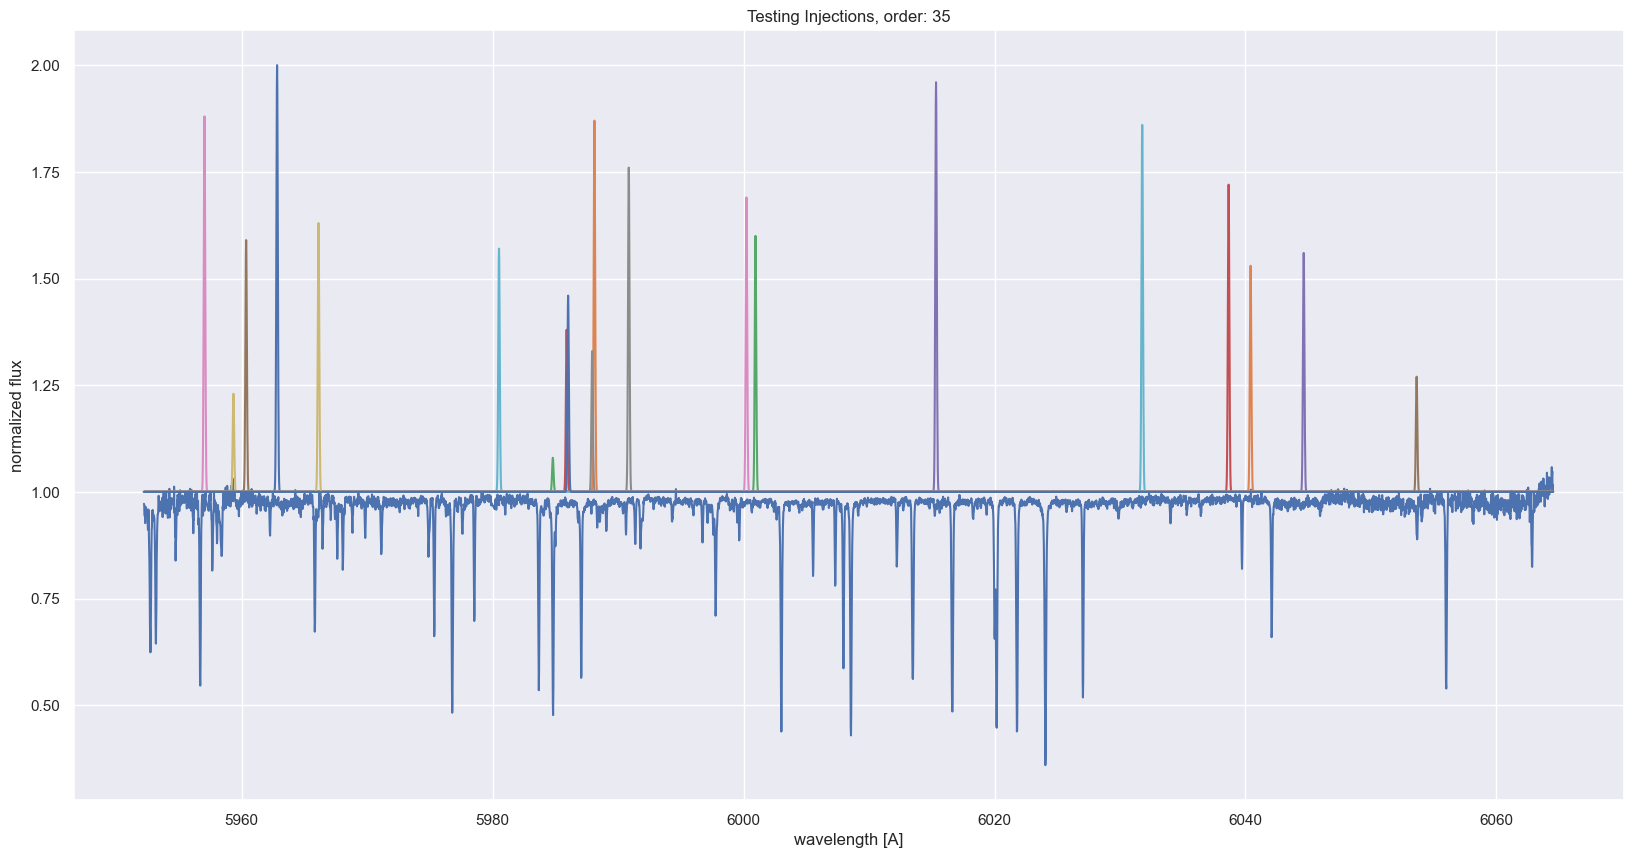

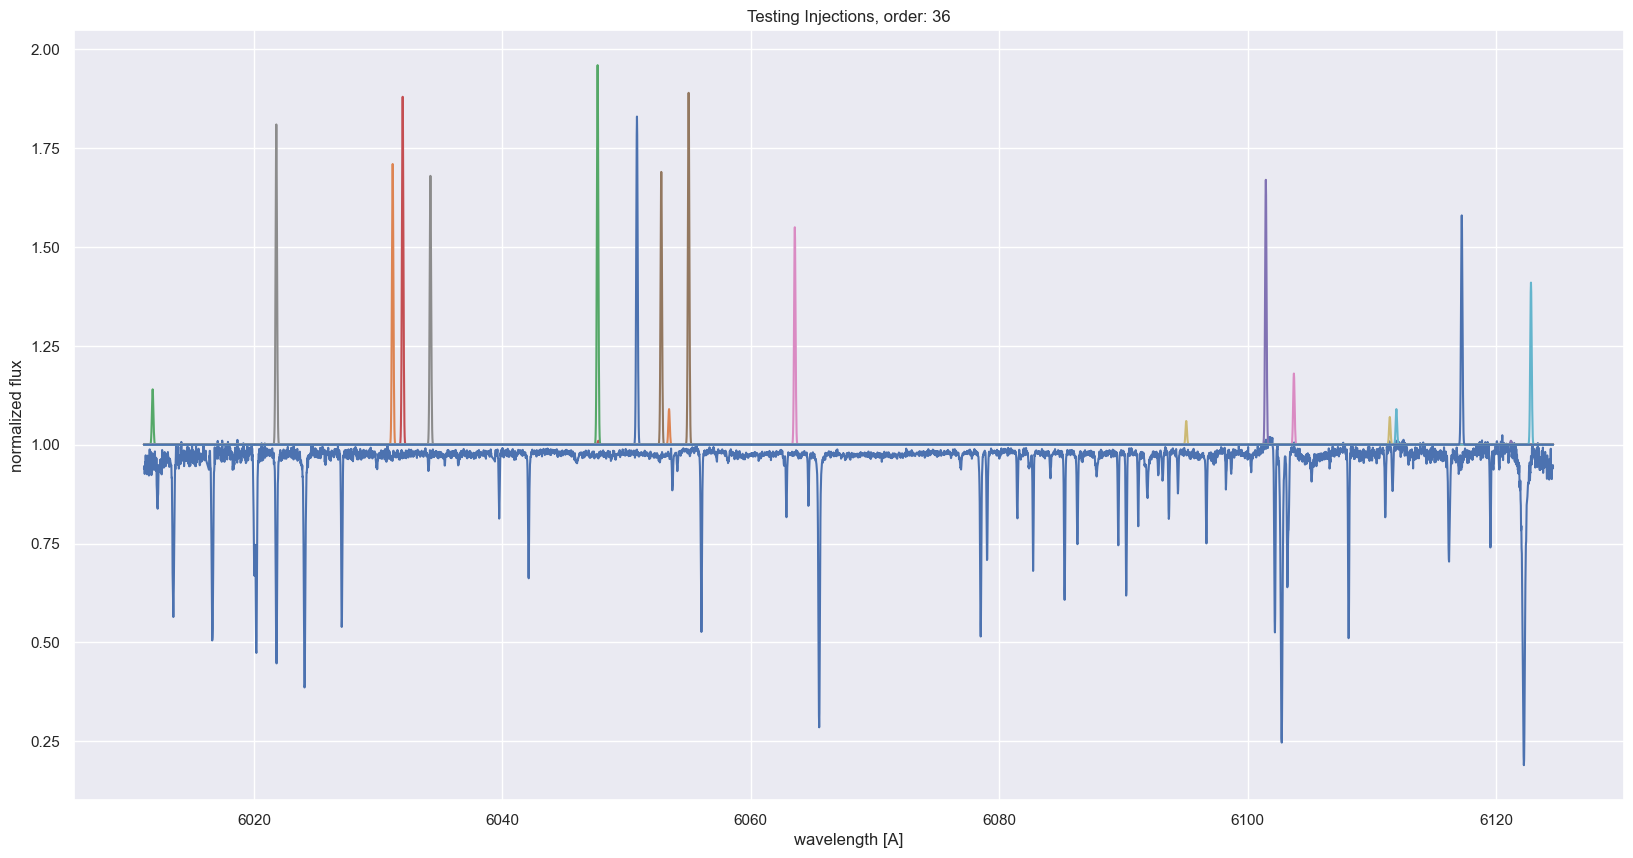

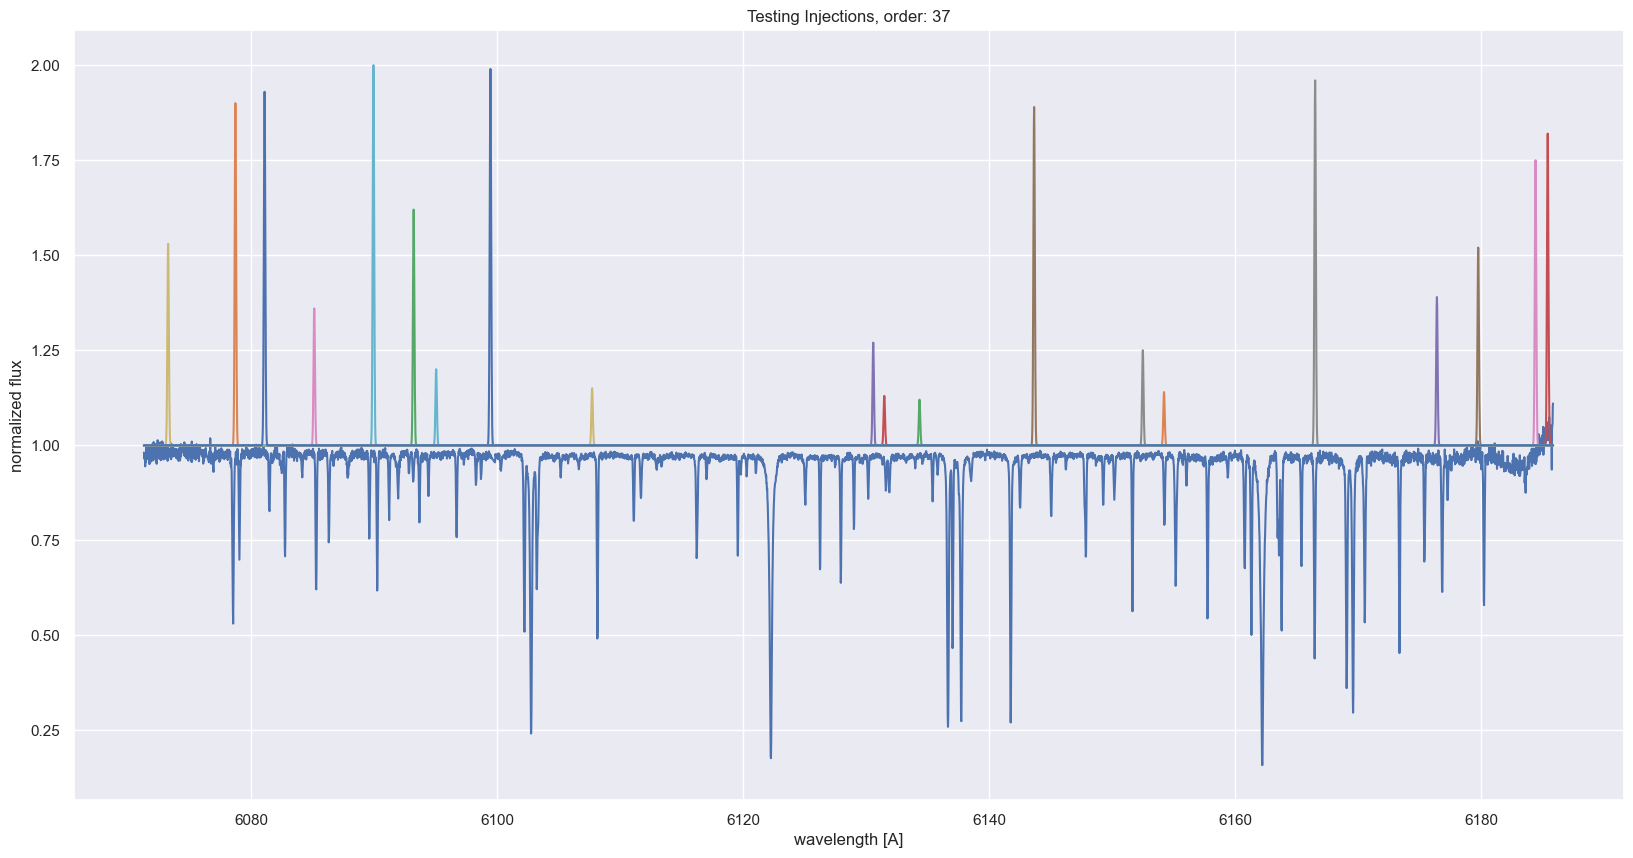

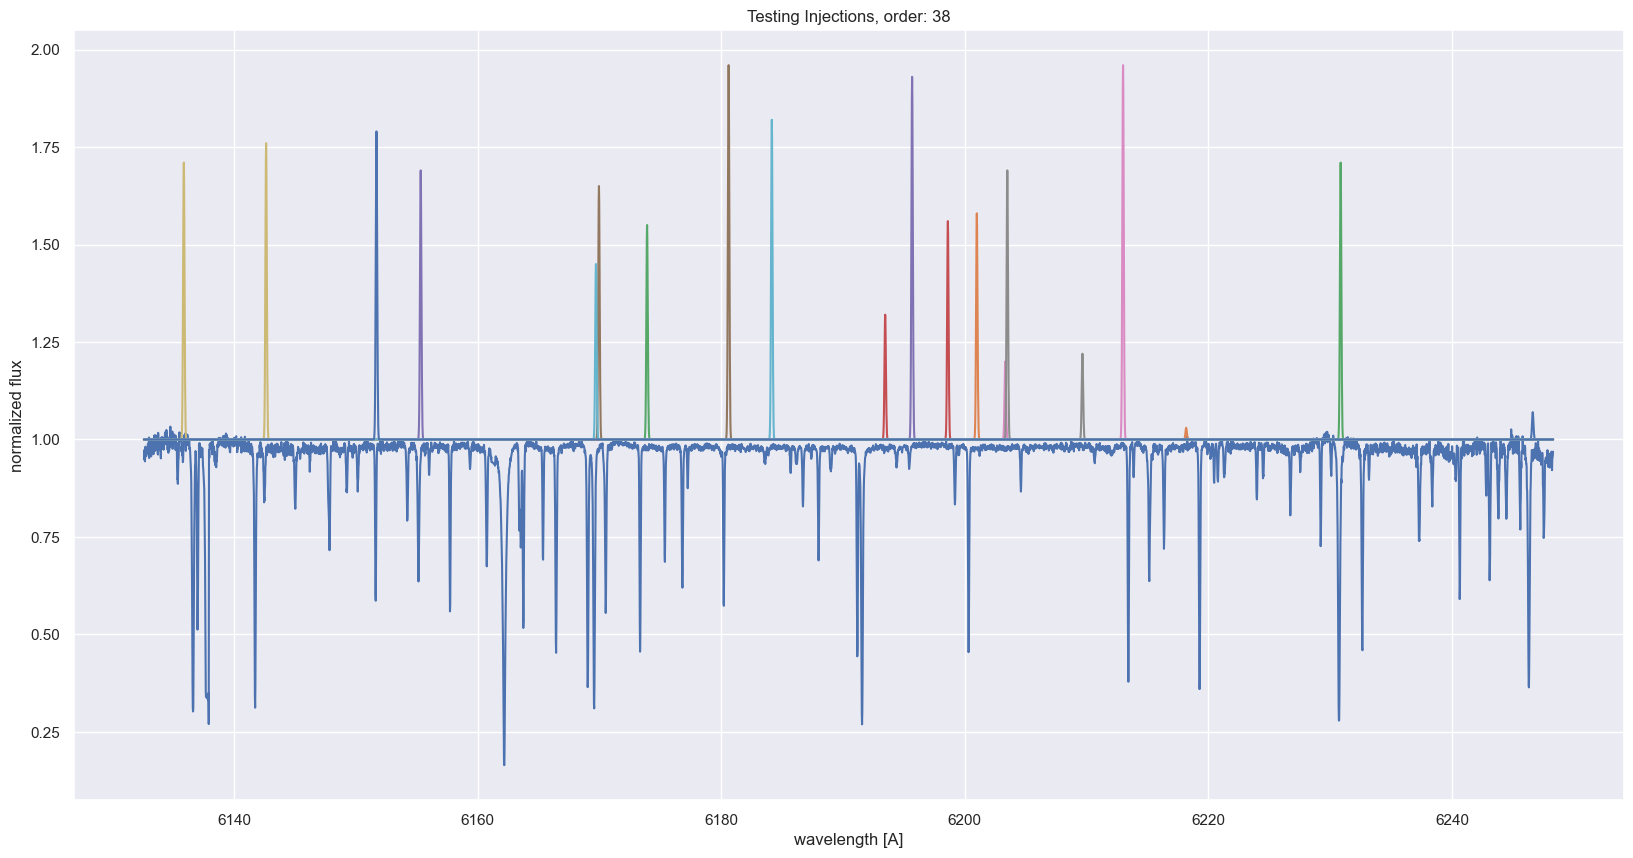

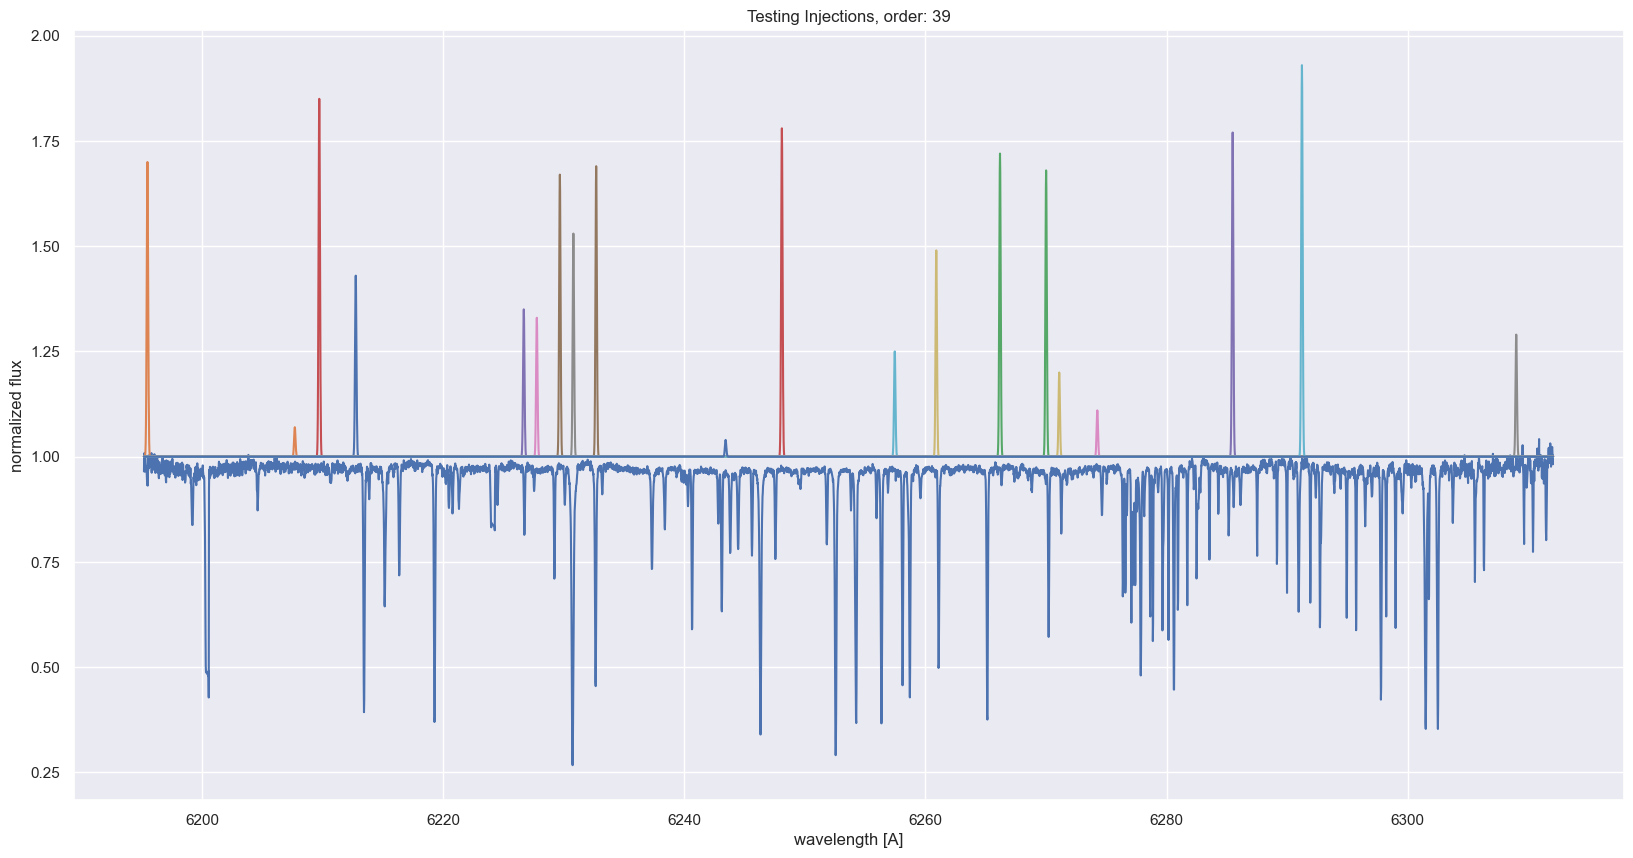

In [215]:
for a in np.arange(25,40): #normalized spectrum 
    plt.figure(figsize = (20,10))
    plt.plot(wls[a],fls[a])
    for i in np.arange(20): #Plots gaussian emissions per normalized spectrum 
        fit_maybe = emission_periodic_gaussian(wls[a],np.random.choice(np.linspace(0.01,1,100)),
                                               np.random.choice(wls[a]), np.median(tot_psfs)
                                              )
        plt.plot(wls[a], fit_maybe)
        plt.ylabel('normalized flux')
        plt.xlabel('wavelength [A]')
        plt.title('Testing Injections, order: ' + str(a))

In [216]:
#collect heightd and widths of onese recovered and ones that werent - injected background, recovered foreground -- 


#make histogram of recovered and injected characteristics (width and height) overlapped 

In [ ]:
#add my favorite plots into my drafted report 